In [1]:
import numpy as np
import torch
import random

from src.restrictions import IntervalUnionRestriction
from src.wrapper import RestrictionWrapper
from examples.agents.td3 import TD3
from examples.envs.navigation import NavigationEnvironment
from examples.restrictors.navigation_restrictor import NavigationRestrictor
from examples.utils import ReplayBuffer

In [2]:
# Tested with seeds 45, 46, 47, 48, 49
seed = 49
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
env_config = {
    'HEIGHT': 15.0,
    'WIDTH': 15.0,
    'STEPS_PER_EPISODE': 60,
    'ACTION_RANGE': 220,
    'DT': 1.0,
    'TIMESTEP_PENALTY_COEFFICIENT': 0.05,
    'REWARD_COLLISION': -1.0,
    'REWARD_GOAL': 5.0,
    'REWARD_COEFFICIENT': 10.0,
    'AGENT_RADIUS': 0.5,
    'AGENT_PERSPECTIVE': 90,
    'AGENT_STEP_SIZE': 1.0,
    'AGENT_X': 1.5,
    'AGENT_Y': 1.5,
    'GOAL_RADIUS': 1.0,
    'GOAL_X': 12.0,
    'GOAL_y': 12.0
}
environment = NavigationEnvironment(env_config)


def do_nothing_on_invalid(env, action, restriction):
    env._cumulative_rewards = {'agent_0': 0.0}
    env.rewards = {'agent_0': 0.0}
    env.trajectory.append([float(env.agent.x),
                           float(env.agent.y)])
    env.current_step += 1
    if env.current_step >= env.STEPS_PER_EPISODE:
        env.truncations = {'agent_0': True}

def interval_projection_fn(env, action, restriction: IntervalUnionRestriction):
    assert isinstance(restriction, IntervalUnionRestriction), 'You must provide an IntervalUnionRestriction object!'
    env.step(np.array([restriction.nearest_element(action[0])], dtype=np.float32))

restrictor = NavigationRestrictor(obstacle_count=7,
                                  obstacle_position_covariance=[[4.0, 0.0], [0.0, 4.0]],
                                  obstacle_mean_size=1.0,
                                  obstacle_variance_size=0.2,
                                  obstacle_size_range=0.5,
                                  start_seed=50,
                                  safety_angle=8,
                                  min_angle=-110.0,
                                  max_angle=110.0)
restricted_environment = RestrictionWrapper(environment, restrictor,
                                            restriction_violation_fns=do_nothing_on_invalid)

In [4]:
td3_config = {
    'state_dim': 6,
    'action_dim': 1,
    'max_action': 110.0,
    'discount': 0.99,
    'tau': 0.005,
    'policy_noise': 0.2,
    'noise_clip:': 0.5,
    'policy_freq': 2,
    'exploration_noise': 0.2,
    'exploration_noise_final': 0.02,
    'exploration_timesteps': 30000,
    'batch_size': 256,
    'train_after_timesteps': 2000,
    'learning_rate_actor': 1e-5,
    'learning_rate_critic': 1e-5
}

total_timesteps = 50000
td3 = TD3(**td3_config)
replay_buffer = ReplayBuffer(state_dim=td3_config['state_dim'], action_dim=td3_config['action_dim'])

In [5]:
evaluation_envs = 20

def evaluate(eval_policy: TD3):
    eval_restrictor = NavigationRestrictor(obstacle_count=7,
                                                       obstacle_position_covariance=[[4.0, 0.0], [0.0, 4.0]],
                                                       obstacle_mean_size=1.0,
                                                       obstacle_variance_size=0.2,
                                                       obstacle_size_range=0.5,
                                                       start_seed=1,
                                                       safety_angle=8,
                                                       min_angle=-110.0,
                                                       max_angle=110.0)
    eval_env = RestrictionWrapper(NavigationEnvironment(env_config),
                                  eval_restrictor,
                                  restriction_violation_fns=do_nothing_on_invalid)

    solved = []
    all_rewards = []
    all_steps = []
    for it in range(evaluation_envs):
        eval_reward = 0.0
        eval_steps = 0
        eval_env.reset()
        for eval_agent in eval_env.agent_iter():
            obs, rew, term, trunc, inf = eval_env.last()
            if eval_agent == 'agent_0':
                eval_steps += 1
                eval_reward += rew
                eval_action = eval_policy.select_action(obs['observation'])
            else:
                eval_action = eval_restrictor.act(obs)

            if term or trunc:
                eval_action = None
                if eval_agent == 'agent_0':
                    solved.append(term)

            eval_env.step(eval_action)

        all_rewards.append(eval_reward)
        all_steps.append(eval_steps)

    return sum(all_rewards) / len(all_rewards), sum(solved) / len(solved), eval_steps

In [ ]:
episode_num = 0
training_timesteps = 0
sample_from_restricted_space = False

ev_reward_all = []
ev_solved_all = []
ev_steps_all = []

exploration_annealing_rate = (td3_config['exploration_noise'] - td3_config['exploration_noise_final']
                              ) / td3_config['exploration_timesteps']
noise_factor = td3_config['exploration_noise']
while training_timesteps < total_timesteps:
    restricted_environment.reset()
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
    observation = None
    action = None
    last_td3_action = None

    for agent in restricted_environment.agent_iter():
        next_observation, reward, termination, truncation, info = restricted_environment.last()

        # Turn of the agent
        if agent == 'agent_0':
            episode_reward += reward
            episode_timesteps += 1

            flattened_next_observation = next_observation['observation']

            if episode_timesteps > 1:
                replay_buffer.add(observation,
                                  last_td3_action,
                                  flattened_next_observation,
                                  reward,
                                  termination or truncation)
            observation = flattened_next_observation

            training_timesteps += 1
            if training_timesteps < td3_config['train_after_timesteps']:
                if sample_from_restricted_space:
                    action = next_observation['restriction'].sample()
                else:
                    action = np.random.uniform(-110.0, 110.0, (1,))
            else:
                det_action = td3.select_action(observation)
                noise = np.random.normal(0, td3_config['max_action'] * noise_factor,
                                         size=td3_config['action_dim'])
                action = (det_action + noise).clip(-td3_config['max_action'], td3_config['max_action'])

                noise_factor = max([noise_factor - exploration_annealing_rate,
                                    td3_config['exploration_noise_final']])

            if training_timesteps >= td3_config['train_after_timesteps']:
                td3.train(replay_buffer, td3_config['batch_size'])
            last_td3_action = action
        # Or restrictor
        else:
            action = restrictor.act(next_observation)

        # None action if episode is done
        if termination or truncation:
            # print(f'{action} for {next_observation["restriction"]}, {restricted_environment.env.agent.x, restricted_environment.env.agent.y}')
            action = None

        restricted_environment.step(action)

        if agent == 'agent_0' and training_timesteps % 500 == 0:
            print('Starting evaluation ...')
            ev_reward, ev_solved, ev_steps = evaluate(td3)
            ev_reward_all.append(ev_reward)
            ev_solved_all.append(ev_solved)
            ev_steps_all.append(ev_steps)

    print(noise_factor)
    print(f'Finished episode {episode_num} with reward {episode_reward} in {episode_timesteps} steps - goal reached: {termination}')

restricted_environment.close()

In [13]:
import pickle

with open('rewards_2.pkl', 'wb') as f:
    pickle.dump(ev_reward_all, f)
with open('solved_2.pkl', 'wb') as f:
    pickle.dump(ev_solved_all, f)
with open('steps_2.pkl', 'wb') as f:
    pickle.dump(ev_steps_all, f)

In [13]:
import pickle

with open('rewards.pkl', 'rb') as f:
    ev_reward_all_2 = pickle.load(f)
with open('solved.pkl', 'rb') as f:
    ev_solved_all_2 = pickle.load(f)
with open('steps.pkl', 'rb') as f:
    ev_steps_all_2 = pickle.load(f)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

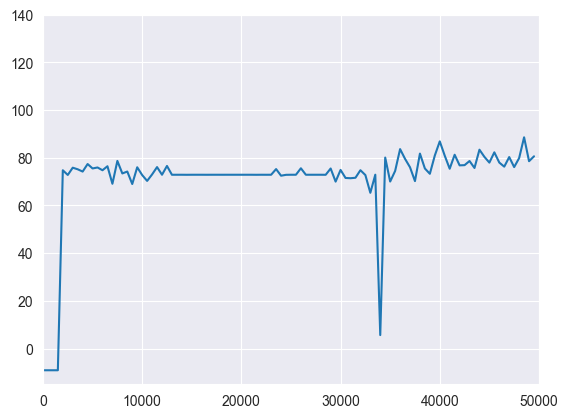

In [8]:
plt.figure()
sns.lineplot(x=range(0, 50000, 500), y=ev_reward_all)
plt.ylim(-15.0, 140.0)
plt.xlim(0.0, 50000.0)
plt.show()

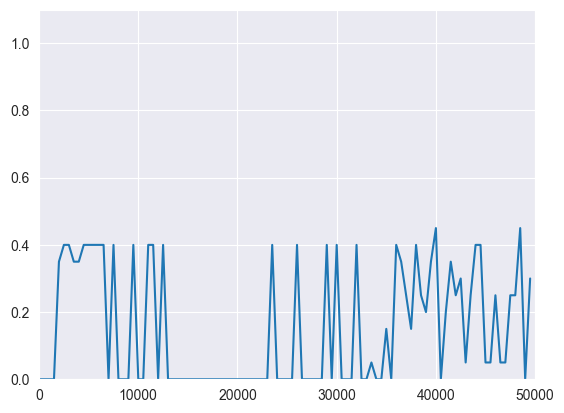

In [9]:
plt.figure()
sns.lineplot(x=range(0, 50000, 500), y=ev_solved_all)
plt.ylim(0.0, 1.1)
plt.xlim(0.0, 50000.0)
plt.show()

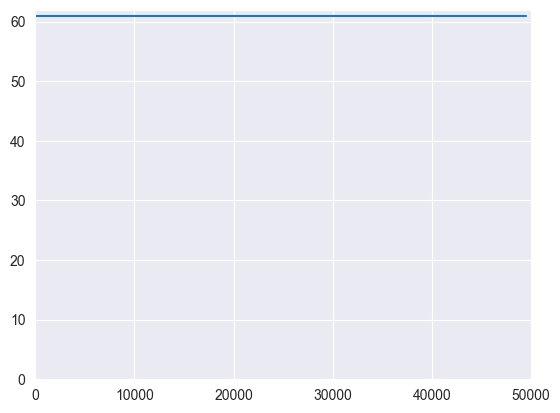

In [12]:
plt.figure()
sns.lineplot(x=range(0, 50000, 500), y=ev_steps_all)
plt.ylim(0.0, 62.0)
plt.xlim(0.0, 50000.0)
plt.show()